In [21]:
import itertools
import json
from contextlib import suppress

import krippendorff
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.font_manager import fontManager, FontProperties
from matplotlib.gridspec import GridSpec
from sklearn.metrics import cohen_kappa_score

from src.constants import Criterion
from src.datamodel import Document
from src.util import ROOT_PATH

kwargs = dict(context='paper', palette='Set1', style='darkgrid', rc={'axes.unicode_minus': False})
with suppress(FileNotFoundError):
    font_path = '~/.local/share/fonts/cmunss.ttf'
    fontManager.addfont(font_path)
    prop = FontProperties(fname=font_path)
    kwargs |= dict(font=prop.get_name())
sns.set_theme(**kwargs)

In [22]:
def docs_to_anns(docs: list[Document], round: int) -> dict[str, list[list[float]]]:
    evals = dict()
    for doc in docs:
        if doc.round != round:
            continue
        for model, summary in doc.model_summaries.items():
            for criterion, anns in summary.anns.items():
                if len(anns) != 3:
                    continue
                if criterion not in evals:
                    evals[criterion] = dict()
                for i, ann in enumerate(anns):
                    if i not in evals[criterion]:
                        evals[criterion][i] = []
                    try:
                        evals[criterion][i].append(int(ann))
                    except ValueError:
                        if model.startswith('llama'):
                            evals[criterion][i].append(np.nan)
                        else:
                            evals[criterion][i].append(3)
    for criterion, anns in evals.items():
        evals[criterion] = list(anns.values())
    return evals

def docs_to_longform(docs: list[Document], round: int) -> pd.DataFrame:
    records = []
    for doc in docs:
        if doc.round != round:
            continue
        for model, summary in doc.model_summaries.items():
            for criterion, anns in summary.anns.items():
                if len(anns) != 3:
                    continue
                for i, ann in enumerate(anns):
                    records.append({
                        'model': model,
                        'criterion': criterion,
                        'annot': f'Ann{i+1}',
                        'value': ann
                    })
    return pd.DataFrame.from_records(records)

def compute_percentages(evals: dict[str, list[list[float]]]) -> dict[str, pd.DataFrame] | None:
    pairwise = {}
    for criterion, anns in evals.items():
        annotators = list(range(len(anns)))
        pairwise[criterion] = np.full((3, 3), np.nan)
        for (ann_1, ann_2) in itertools.combinations(annotators, 2):
            kappa = sum(int(a == b) for a, b in zip(anns[ann_1], anns[ann_2])) / len(anns[ann_1])
            pairwise[criterion][ann_1, ann_2] = kappa
            pairwise[criterion][ann_2, ann_1] = kappa
        pairwise[criterion] = pairwise[criterion][1:, :2]
    return pairwise

def compute_kappas(evals: dict[str, list[list[float]]]) -> dict[str, pd.DataFrame] | None:
    pairwise = {}
    for criterion, anns in evals.items():
        annotators = list(range(len(anns)))
        pairwise[criterion] = np.full((3, 3), np.nan)
        for (ann_1, ann_2) in itertools.combinations(annotators, 2):
            a, b = zip(*[(a, b) for a, b in zip(anns[ann_1], anns[ann_2]) if not(pd.isna(a) or pd.isna(b))])
            kappa = cohen_kappa_score(a, b, weights='quadratic')
            pairwise[criterion][ann_1, ann_2] = kappa
            pairwise[criterion][ann_2, ann_1] = kappa
        pairwise[criterion] = pairwise[criterion][1:, :2]
    return pairwise

def compute_alphas(evals: dict[str, list[list[float]]]) -> pd.DataFrame:
        alphas = []
        for criterion, anns in evals.items():
            alpha = krippendorff.alpha(
                reliability_data=anns,
                value_domain=[1, 2, 3, 4, 5],
                level_of_measurement='ordinal'
            )
            k = len(set([val for ann in anns for val in ann]))
            alphas.append({'criterion': criterion, 'a': float(alpha), 'docs': len(anns[0]), 'k': k, 'n': len(anns)})
        return pd.DataFrame.from_records(alphas)

def pairwise_heatmap(evals: dict[str, list[list[float]]], filename: str = None):

    plt.figure(figsize=(8.45, 2))
    gs = GridSpec(1, 6, width_ratios=[1, 1, 1, 1, 1, 0.1])  # 6th column for colorbar

    for idx, (metric, data_matrix) in enumerate(evals.items()):
        ax = plt.subplot(gs[idx])
        df = pd.DataFrame(data_matrix, index=['Ann3', 'Ann2'], columns=['Ann1', 'Ann3'])

        sns.heatmap(df, ax=ax, cmap='magma', vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', cbar=False)

        ax.set_title(metric)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=90)
        if idx > 0:
            ax.set_yticklabels([])

    cbar_ax = plt.subplot(gs[5])
    norm = plt.Normalize(vmin=-1, vmax=1)
    sm = plt.cm.ScalarMappable(cmap='magma', norm=norm)
    plt.colorbar(sm, cax=cbar_ax)

    plt.tight_layout()

    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches='tight')

def displot(long_df, filename: str = None):

    kwargs = dict(context='paper', palette='Set2', style='darkgrid', rc={'axes.unicode_minus': False})
    with suppress(FileNotFoundError):
        font_path = '~/.local/share/fonts/cmunss.ttf'
        fontManager.addfont(font_path)
        prop = FontProperties(fname=font_path)
        kwargs |= dict(font=prop.get_name())
    sns.set_theme(**kwargs)

    g = sns.displot(data=long_df, x='value', hue='annot', col='criterion', kind='hist', stat='proportion', discrete=True, common_norm=False, multiple='dodge', shrink=0.7, palette='Set2', edgecolor='k', alpha=0.7, height=1.9, aspect=0.76)
    g.set_titles('{col_name}')
    g.set_xlabels('')
    g.set_ylabels('')
    g.axes[0,0].set_yticks(np.arange(0, 1.25, 0.25))
    for ax in g.axes.flat:
        ax.set_xticks([1, 2, 3, 4, 5])

    legend = g.legend
    legend.set_title(None)

    handles, labels = legend.legend_handles, [t.get_text() for t in legend.texts]

    g.legend.remove()
    g.figure.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=len(labels), frameon=False)

    plt.tight_layout()

    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches='tight')

# Spanish

In [23]:
data_path = ROOT_PATH.resolve() / 'data' / 'es'
with (data_path / 'BASSE.es.round_0.jsonl').open() as f:
    data = [Document.from_json(json.loads(line)) for line in f]
with (data_path / 'BASSE.es.jsonl').open() as f:
    data.extend([Document.from_json(json.loads(line)) for line in f])

In [24]:
anns_0 = docs_to_anns(data, round=0)
anns_1 = docs_to_anns(data, round=1)
anns_2 = docs_to_anns(data, round=2)

In [25]:
results_path = ROOT_PATH / 'results' / 'agreement' / 'es'
results_path.mkdir(parents=True, exist_ok=True)

In [26]:
def pivot_df(df):
    return df.pivot(index='docs', columns='criterion', values='a').reset_index()

alpha_0 = pivot_df(compute_alphas(anns_0))
alpha_1 = pivot_df(compute_alphas(anns_1))
alpha_2 = pivot_df(compute_alphas(anns_2))

alpha_df = pd.concat([alpha_0, alpha_1, alpha_2], ignore_index=True)
alpha_df['round'] = range(1, len(alpha_df) + 1)
columns_order = ['round', 'docs'] + list(Criterion)
alpha_df = alpha_df[columns_order]

with (results_path / 'alpha.es.tex').open('w') as wf:
    wf.write(alpha_df.to_latex(index=False, float_format='%.2f'))

alpha_df

criterion,round,docs,Coherence,Consistency,Fluency,Relevance,5W1H
0,1,210,0.314838,0.178336,0.126733,0.224127,0.390090
1,2,210,0.657771,0.373172,0.348376,0.488041,0.581002
2,3,105,0.293815,0.186981,0.338088,0.203626,0.393331


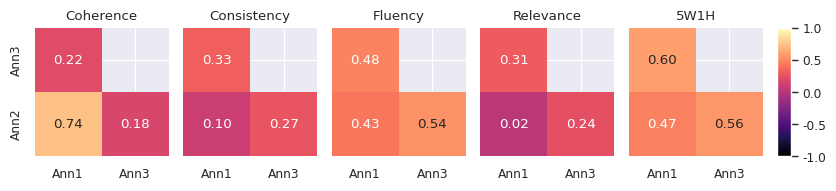

In [27]:
k = compute_kappas(anns_0)
pairwise_heatmap(k, results_path / 'kappa-round1.es.heatmap.pdf')

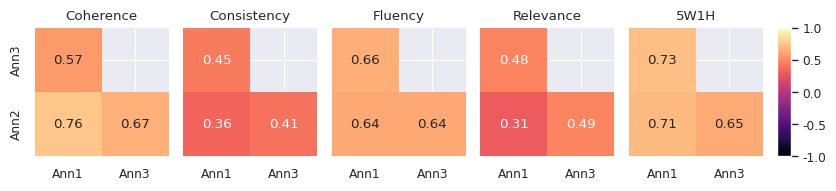

In [28]:
k = compute_kappas(anns_1)
pairwise_heatmap(k, results_path / 'kappa-round2.es.heatmap.pdf')

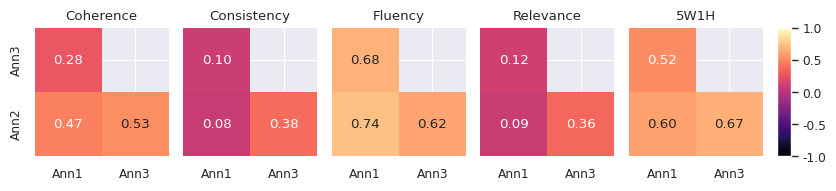

In [29]:
k = compute_kappas(anns_2)
pairwise_heatmap(k, results_path / 'kappa-round3.es.heatmap.pdf')

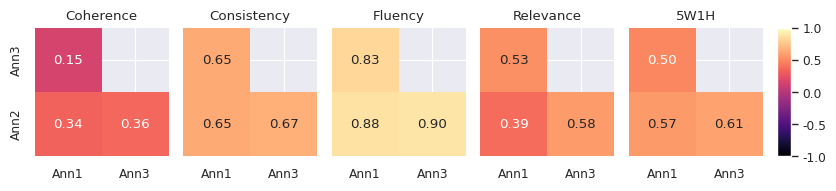

In [30]:
p = compute_percentages(anns_2)
pairwise_heatmap(p, results_path / 'percentage-round3.es.heatmap.pdf')

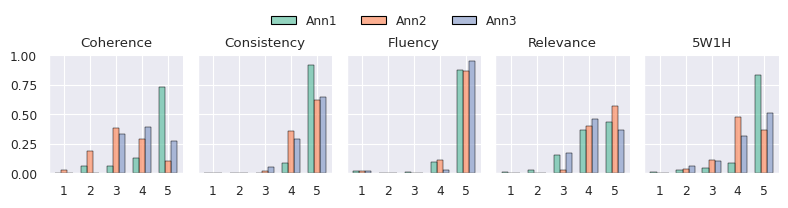

In [31]:
long_df = docs_to_longform(data, round=2)
displot(long_df, results_path / 'scores-round3.es.histogram.pdf')

# Basque

In [32]:
data_path = ROOT_PATH.resolve() / 'data' / 'eu'
with (data_path / 'BASSE.eu.round_0.jsonl').open() as f:
    data = [Document.from_json(json.loads(line)) for line in f]
with (data_path / 'BASSE.eu.jsonl').open() as f:
    data.extend([Document.from_json(json.loads(line)) for line in f])

In [33]:
anns_0 = docs_to_anns(data, round=0)
anns_1 = docs_to_anns(data, round=1)
anns_2 = docs_to_anns(data, round=2)

In [34]:
results_path = ROOT_PATH / 'results' / 'agreement' / 'eu'
results_path.mkdir(parents=True, exist_ok=True)

In [35]:
def pivot_df(df):
    return df.pivot(index='docs', columns='criterion', values='a').reset_index()

alpha_0 = pivot_df(compute_alphas(anns_0))
alpha_1 = pivot_df(compute_alphas(anns_1))
alpha_2 = pivot_df(compute_alphas(anns_2))

alpha_df = pd.concat([alpha_0, alpha_1, alpha_2], ignore_index=True)
alpha_df['round'] = range(1, len(alpha_df) + 1)
columns_order = ['round', 'docs'] + list(Criterion)
alpha_df = alpha_df[columns_order]

with (results_path / 'alpha.eu.tex').open('w') as wf:
    wf.write(alpha_df.to_latex(index=False, float_format='%.2f'))

alpha_df

criterion,round,docs,Coherence,Consistency,Fluency,Relevance,5W1H
0,1,210,0.386152,0.556674,0.682181,0.336757,0.555300
1,2,210,0.594383,0.631478,0.757727,0.535456,0.640970
2,3,105,0.655689,0.444320,0.695309,0.625776,0.719709


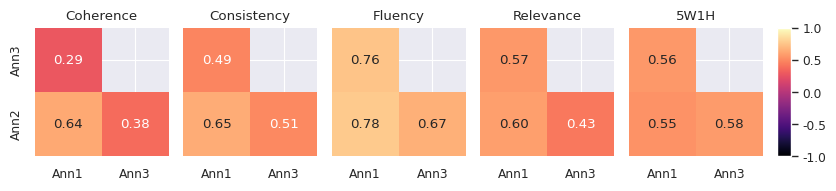

In [36]:
k = compute_kappas(anns_0)
pairwise_heatmap(k, results_path / 'kappa-round1.eu.heatmap.pdf')

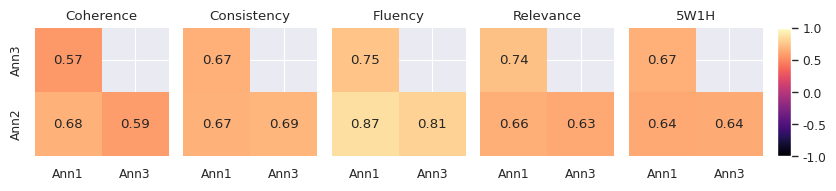

In [37]:
k = compute_kappas(anns_1)
pairwise_heatmap(k, results_path / 'kappa-round2.eu.heatmap.pdf')

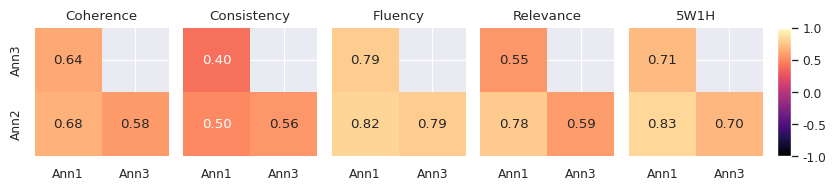

In [38]:
k = compute_kappas(anns_2)
pairwise_heatmap(k, results_path / 'kappa-round3.eu.heatmap.pdf')

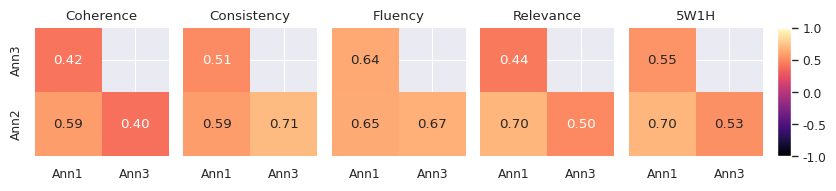

In [39]:
p = compute_percentages(anns_2)
pairwise_heatmap(p, results_path / 'percentage-round3.eu.heatmap.pdf')

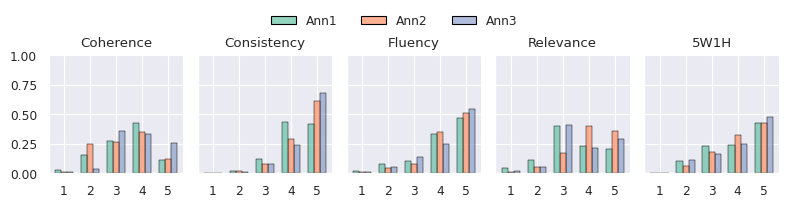

In [40]:
long_df = docs_to_longform(data, round=2)
displot(long_df, results_path / 'scores-round3.eu.histogram.pdf')